<a href="https://colab.research.google.com/github/simonEllershaw/latent_variable_OOD/blob/main/transformer_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pip transformers torch
# ! pip install -q kaggle

In [2]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [3]:
# ! kaggle datasets download tboyle10/medicaltranscriptions -p data/
# ! unzip data/clinc150_uci.zip -d data

In [4]:
import json
with open('/content/data/clinc150_uci/data_full.json') as f:
  data = json.load(f)

In [5]:
data.keys()

dict_keys(['oos_val', 'val', 'train', 'oos_test', 'test', 'oos_train'])

In [6]:
in_scope_data = {k: v for k,v in data.items() if 'oos' not in k}

In [7]:
from transformers import AutoTokenizer

checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [8]:
in_scope_data['train'][:10]

[['what expression would i use to say i love you if i were an italian',
  'translate'],
 ["can you tell me how to say 'i do not speak much spanish', in spanish",
  'translate'],
 ["what is the equivalent of, 'life is good' in french", 'translate'],
 ["tell me how to say, 'it is a beautiful morning' in italian", 'translate'],
 ['if i were mongolian, how would i say that i am a tourist', 'translate'],
 ["how do i say 'hotel' in finnish", 'translate'],
 ["i need you to translate the sentence, 'we will be there soon' into portuguese",
  'translate'],
 ['please tell me how to ask for a taxi in french', 'translate'],
 ["can you tell me how i would say, 'more bread please' in french",
  'translate'],
 ["what is the correct way to say 'i am a visitor' in french", 'translate']]

In [9]:
from torch.utils.data import Dataset

class HuggingFaceDataset(Dataset):
  def __init__(self, texts, labels, label2id, tokenizer):
    self._dict = tokenizer(texts, truncation=True)
    self._dict['labels'] = [label2id[label] for label in labels]

  def __len__(self):
        return len(self._dict["input_ids"])

  def __getitem__(self, idx):
      return {k: v[idx] for k, v in self._dict.items()}

label_names = sorted({label for _, label in in_scope_data['train']})
id2label = dict(enumerate(sorted(label_names)))
label2id = {v: k for k, v in id2label.items()}

datasets_hf = {}
for key, dataset in in_scope_data.items():
  texts, labels = map(list,zip(*dataset))
  datasets_hf[key] = HuggingFaceDataset(texts, labels, label2id, tokenizer) 

(array([1.013e+03, 4.410e+03, 6.366e+03, 2.022e+03, 7.220e+02, 3.610e+02,
        6.800e+01, 3.200e+01, 4.000e+00, 2.000e+00]),
 array([ 3. ,  6.4,  9.8, 13.2, 16.6, 20. , 23.4, 26.8, 30.2, 33.6, 37. ]),
 <a list of 10 Patch objects>)

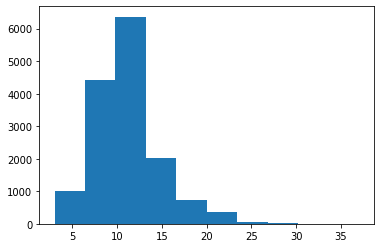

In [10]:
import matplotlib.pyplot as plt
plt.hist([len(sample['input_ids']) for sample in datasets_hf['train']])

In [11]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [12]:
from transformers import TrainingArguments

args = TrainingArguments(
    "inscope_text_classification",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,
    num_train_epochs=10,
    weight_decay=0.01,
    group_by_length=True,
    warmup_ratio=0.1,
    load_best_model_at_end=True
)


In [13]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
  """Called to compute validation metrics at each evaluation step of training."""
  logits, labels = eval_pred
  labels = labels.flatten()
  predictions = np.argmax(logits, axis=-1).flatten()

  precision, recall, f1, _ = precision_recall_fscore_support(
      labels, predictions, average='macro', zero_division=0
  )
  metrics = {"f1": f1, "precision": precision, "recall": recall}
  return metrics

In [14]:
from transformers import Trainer, DataCollatorWithPadding, EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=datasets_hf['train'],
    eval_dataset=datasets_hf['val'],
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 15000
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4690
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: simon_ellershaw (use `wandb login --relogin` to force relogin)


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,3.507900,1.038306,0.903988,0.915600,0.907333
2,0.469100,0.221534,0.962404,0.965474,0.962667
3,0.108800,0.170812,0.965189,0.967871,0.965333
4,0.050000,0.182443,0.966577,0.969988,0.966333
5,0.033600,0.170132,0.971933,0.973894,0.972000
6,0.020400,0.163326,0.972200,0.974271,0.972333
7,0.014200,0.160175,0.973853,0.975546,0.974000
8,0.008700,0.167610,0.975209,0.977163,0.975333
9,0.006900,0.166190,0.975937,0.977739,0.976000
10,0.005000,0.167297,0.975598,0.977366,0.975667


***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32
Saving model checkpoint to inscope_text_classification/checkpoint-469
Configuration saved in inscope_text_classification/checkpoint-469/config.json
Model weights saved in inscope_text_classification/checkpoint-469/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32
Saving model checkpoint to inscope_text_classification/checkpoint-938
Configuration saved in inscope_text_classification/checkpoint-938/config.json
Model weights saved in inscope_text_classification/checkpoint-938/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32
Saving model checkpoint to inscope_text_classification/checkpoint-1407
Configuration saved in inscope_text_classification/checkpoint-1407/config.json
Model weights saved in inscope_text_classification/checkpoint-1407/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32
Saving model chec

TrainOutput(global_step=4690, training_loss=0.42247336266645746, metrics={'train_runtime': 664.0677, 'train_samples_per_second': 225.881, 'train_steps_per_second': 7.063, 'total_flos': 883268415517824.0, 'train_loss': 0.42247336266645746, 'epoch': 10.0})